In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [2]:
def plot_data(data, x, y, outdir, tag, title, timing=None, smooth=1):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[y])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[y] = smoothed_x
            
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
        if timing:
            data = data[data.timing == timing].drop('timing', axis=1)

    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.set(style="whitegrid", font_scale=1.5)
    sns.set_palette('Set2') # or husl
    if 'timing' in data.columns:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag, style='timing')
    else:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag)
    ax.grid(True, alpha=0.8, linestyle=':')
    ax.legend(loc='best').set_draggable(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if timing:
        title = f'{title}-{timing}'
    outpath = f'{outdir}/{title}.png'
    ax.set_title(title)
    fig.savefig(outpath)
    fig.show()
    print(f'Plot Path: {outpath}')

def get_datasets(files, tag, condition=None):
    unit = 0
    datasets = []
    for f in files:
        assert f.endswith('log.txt')
        data = pd.read_csv(f, sep='\t')

        data.insert(len(data.columns), tag, condition)

        datasets.append(data)
        unit +=1

    return datasets

In [16]:
import tensorflow as tf
import tensorflow_probability as tfd
shape = (2, 4)
x_ = tf.random.normal(shape)
x = tf.nn.softmax(x_)
y_ = np.random.randint(0, 4, 2)
y = tf.one_hot(y_, 4)
tf.keras.losses.categorical_crossentropy(y, x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.201805 , 1.7890831], dtype=float32)>

In [26]:
np.ones(10) * np.inf

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

In [64]:
bs = 5
n = 10
n2 = 15
action_type = np.random.randint(0, n-1, (bs,))
card_rank_mask = np.arange(bs * (n-1)).reshape(bs, n-1, 1)
print(action_type)
card_rank_mask

[7 4 8 3 2]


IndexError: index 7 is out of bounds for axis 0 with size 5

In [77]:
def vtrace_from_importance_weights(reward, value, next_value, pi, mu, discount, lambda_=1,
    c_clip=1, rho_clip=1.0, rho_clip_pg=1.0,
    name='vtrace_from_importance_weights'):

    log_rhos = tf.convert_to_tensor(tf.math.log(pi/mu), dtype=tf.float32)
    discounts = tf.convert_to_tensor(discount, dtype=tf.float32)
    rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
    values = tf.convert_to_tensor(value, dtype=tf.float32)
    bootstrap_value = tf.convert_to_tensor(next_value[-1], dtype=tf.float32)
    if rho_clip is not None:
        clip_rho_threshold = tf.convert_to_tensor(rho_clip, dtype=tf.float32)
    if rho_clip_pg is not None:
        clip_pg_rho_threshold = tf.convert_to_tensor(rho_clip_pg, dtype=tf.float32)

    # Make sure tensor ranks are consistent.
    rho_rank = log_rhos.shape.ndims  # Usually 2.
    values.shape.assert_has_rank(rho_rank)
    bootstrap_value.shape.assert_has_rank(rho_rank - 1)
    discounts.shape.assert_has_rank(rho_rank)
    rewards.shape.assert_has_rank(rho_rank)
    if clip_rho_threshold is not None:
        clip_rho_threshold.shape.assert_has_rank(0)
    if clip_pg_rho_threshold is not None:
        clip_pg_rho_threshold.shape.assert_has_rank(0)

    rhos = tf.exp(log_rhos)
    if clip_rho_threshold is not None:
        clipped_rhos = tf.minimum(clip_rho_threshold, rhos, name='clipped_rhos')
    else:
        clipped_rhos = rhos

    cs = tf.minimum(c_clip, rhos, name='cs')
    # Append bootstrapped value to get [v1, ..., v_t+1]
    values_t_plus_1 = tf.concat(
        [values[1:], tf.expand_dims(bootstrap_value, 0)], axis=0)
    deltas = clipped_rhos * (rewards + discounts * values_t_plus_1 - values)

    # Note that all sequences are reversed, computation starts from the back.
    sequences = (
        tf.reverse(discounts, axis=[0]),
        tf.reverse(cs, axis=[0]),
        tf.reverse(deltas, axis=[0]),
    )
    # V-trace vs are calculated through a scan from the back to the beginning
    # of the given trajectory.
    def scanfunc(acc, sequence_item):
        discount_t, c_t, delta_t = sequence_item
        return delta_t + discount_t * c_t * acc

    initial_values = tf.zeros_like(bootstrap_value)
    vs_minus_v_xs = tf.scan(
        fn=scanfunc,
        elems=sequences,
        initializer=initial_values,
        parallel_iterations=1,
        back_prop=False,
        name='scan')
    # Reverse the results back to original order.
    vs_minus_v_xs = tf.reverse(vs_minus_v_xs, [0], name='vs_minus_v_xs')

    # Add V(x_s) to get v_s.
    vs = tf.add(vs_minus_v_xs, values, name='vs')

    # Advantage for policy gradient.
    vs_t_plus_1 = tf.concat([
        vs[1:], tf.expand_dims(bootstrap_value, 0)], axis=0)
    if clip_pg_rho_threshold is not None:
        clipped_pg_rhos = tf.minimum(clip_pg_rho_threshold, rhos,
                                   name='clipped_pg_rhos')
    else:
        clipped_pg_rhos = rhos
    pg_advantages = (
        clipped_pg_rhos * (rewards + discounts * vs_t_plus_1 - values))

    # Make sure no gradients backpropagated through the returned values.
    return tf.stop_gradient(vs), tf.stop_gradient(pg_advantages)

tf.nest.map_structure(lambda x: x.numpy(), vtrace_from_importance_weights(**tf.nest.map_structure(
    lambda x: tf.convert_to_tensor(x, tf.float32), values)))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.scan(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.scan(fn, elems))


(array([[ 9.209749 ,  8.690623 ,  5.6069465],
        [ 9.360001 ,  5.378809 , 10.760001 ]], dtype=float32),
 array([[ 9.209749 ,  9.446628 ,  4.9402804],
        [15.580001 ,  4.0454755, 16.946669 ]], dtype=float32))

In [14]:
A = np.array([[3, 0], [5, 1]])
x = np.array([.5, .5])
y = np.array([.75, .25])
i = 0
x * ((A @ y) - x @ A @ y)

array([-0.4375,  0.4375])

In [13]:
B = np.array([[3, 5], [0, 1]])
x = np.array([.5, .5])
y = np.array([.75, .25])
i = 1
y * ((x @ B) - x @ B @ y)

array([-0.28125,  0.28125])

In [20]:
%%timeit
np.swapaxes(x, 0, 1)

10.7 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [150]:
%%timeit 
random.choice(range(10))

815 ns ± 124 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [218]:
np.any([1])

True

In [219]:
import ray

/Users/aptx4869/opt/anaconda3/envs/grl/lib/python3.8/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [227]:
from nn.func import mlp
l = mlp([10])
x = np.random.normal(size=(2, 3))
l(x)

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[-1.8751314 ,  1.1574111 ,  0.28891563, -1.036958  , -0.30806425,
        -0.942376  ,  0.14197487, -0.18942305,  1.0531654 , -2.1253295 ],
       [ 0.13698195, -0.37173527, -0.60122806,  0.07042462,  0.93663615,
         0.24715364, -0.63460284, -0.41311222, -0.41269708,  1.1034516 ]],
      dtype=float32)>

In [254]:
x = np.random.uniform(0.3, .6, 5)
def compute(x, new=None):
    q = np.exp(x)
    p = q / np.sum(q)
    if new is not None:
        q = np.exp(x + new)
        p = q / np.sum(q)
    return q, p
q, p = compute(x, 0)
print(x, q, p, sep='\n')
new = np.random.uniform(-.1, .1, 5)
q, p = compute(x, new)
print(new, q, p, sep='\n')

[0.48889034 0.50763433 0.3878819  0.44746298 0.34857739]
[1.63050591 1.66135632 1.47385572 1.56433838 1.41705021]
[0.21046644 0.21444862 0.19024596 0.2019255  0.18291348]
[ 0.03446378  0.07926115 -0.0098966   0.09980731  0.00971384]
[1.68767884 1.79839658 1.45934149 1.72852818 1.43088228]
[0.20823131 0.22189203 0.18005831 0.21327144 0.17654692]


In [269]:
score = 1-np.linspace(.4, .6, 5)
score[-1] = .3
x = np.exp(score)
x / np.sum(x)

array([0.22433632, 0.2133953 , 0.20298789, 0.19308806, 0.16619243])

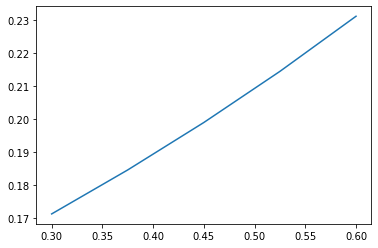

In [276]:
x = np.linspace(.3, .6, 5)
y = np.exp(x)
y /= np.sum(y)
plt.plot(x, y)

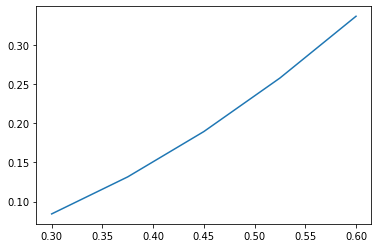

In [279]:
x = np.linspace(.3, .6, 5)
y = (x)**2
y /= np.sum(y)
plt.plot(x, y)

In [70]:
np.shape(10)

IndexError: tuple index out of range

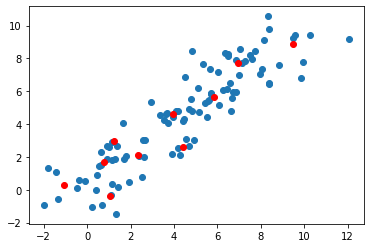

In [206]:
def nearest_cluster_idx(centroids, feat):
    return np.argmin(np.mean((centroids - feat[None])**2, -1))

def kmean(data, k, n):
    max_feat = np.max(data, 0)
    min_feat = np.min(data, 0)
    step = data.shape[0] // k
    centroids = data[:k]
    
    for _ in range(n):
        feats = [[] for _ in range(k)]
        for feat in data:
            i = nearest_cluster_idx(centroids, feat)
            feats[i].append(feat)
        centroids = np.array([np.mean(fs, axis=0) for fs in feats])
    return centroids

data = np.concatenate([np.random.normal(i, 1, (10, 2)) for i in range(10)], 0)
np.random.shuffle(data)
centroids = kmean(data, 10, 100)
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r')
plt.show()

In [181]:
b_e = tf.expand_dims(b, 1)
a_t = tf.transpose(a, [0, 2, 1])
x = tf.squeeze(tf.matmul(b_e, a_t))
tf.where(x == 0, -1e10, x)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-1.0000000e+10, -4.3082278e-02,  7.8758178e-03, -1.0000000e+10,
        -5.6906357e-02],
       [ 1.9747494e-03, -1.0000000e+10, -1.0000000e+10, -1.0000000e+10,
        -1.0000000e+10]], dtype=float32)>

In [219]:
import psutil
process = pszutil.Process()
process.memory_info().rss

156672000

In [284]:
d = {'a': 10, 'b': 20}
set(d.keys())

{'a', 'b'}

In [123]:
list(zip(*[]))

[]

In [122]:
from utility.utils import flatten_dict, batch_dicts
def merge(agent_eids, agent_action, agent_terms, 
          other_eids, other_action, other_terms):
    agent_action = list(zip(*agent_action))
    agent_terms = flatten_dict(agent_terms)
    other_action = list(zip(*other_action))
    other_terms = flatten_dict(other_terms)
    assert len(agent_eids) == len(agent_action) == len(agent_terms), (len(agent_eids), len(agent_action), len(agent_terms))
    assert len(other_eids) == len(other_action) == len(other_terms), (len(other_eids), len(other_action), len(other_terms))
    i = 0
    j = 0
    action, terms = [], []
    while i != len(agent_eids) and j != len(other_eids):
        if agent_eids[i] < other_eids[j]:
            action.append(agent_action[i])
            terms.append(agent_terms[i])
            i += 1
        else:
            action.append(other_action[j])
            terms.append(other_terms[j])
            j += 1
    while i != len(agent_eids):
        action.append(agent_action[i])
        terms.append(agent_terms[i])
        i += 1
    while j != len(other_eids):
        action.append(other_action[j])
        terms.append(other_terms[j])
        j += 1
    print(list(zip(*action)))
    return tuple(map(np.stack, zip(*action))), batch_dicts(terms)

eids1 = [1, 3, 4]
eids2 = [0, 2, 5, 6, 7]
a1 = ([1, 3, 4], [11, 13, 14])
a2 = ([0, 2, 5, 6, 7], [10, 12, 15, 16, 17])
t1 = {
    'a': [1, 3, 4],
    'b': [1, 3, 4]
}
t2 = {
    'a': [0, 2, 5, 6, 7],
    'b': [0, 2, 5, 6, 7]
}
merge(eids1, a1, t1, eids2, a2, t2)

[(0, 1, 2, 3, 4, 5, 6, 7), (10, 11, 12, 13, 14, 15, 16, 17)]


((array([0, 1, 2, 3, 4, 5, 6, 7]), array([10, 11, 12, 13, 14, 15, 16, 17])),
 {'a': array([0, 1, 2, 3, 4, 5, 6, 7]), 'b': array([0, 1, 2, 3, 4, 5, 6, 7])})